In [71]:
import torch
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean
from torch_geometric.nn import MetaLayer
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.insert (0,'../python')
import bbll
import multiprocessing
import json
from array import array
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
from importlib import reload
from torch.utils.data import DataLoader, TensorDataset
import swats

In [2]:
weight_name = "weightr"
num_fold = 5
variable_names=[weight_name,'MJJ','dEtaJJ','PtZZJJOHtZZJJ','MZZ','PtZZ','PtL1','EtaL1','PhiL1','EL1','PIDL1',
               'PtL2','EtaL2','PhiL2','EL2','PIDL2',
               'PtL3','EtaL3','PhiL3','EL3','PIDL3',
               'PtL4','EtaL4','PhiL4','EL4','PIDL4',
               'PtJ1','EtaJ1','PhiJ1','EJ1','PIDJ1',
               'PtJ2','EtaJ2','PhiJ2','EJ2','PIDJ2']
unused_variable=[weight_name]
#unused_variable=[weight_name,"is_em","is_me","is_ee","is_mm",'process_id']
#unused_variable=[weight_name,"is_em","is_me",'process_id',"m_hh_truth","bb_m","bb_deltar","ll_m"]
dim = len(variable_names)-len(unused_variable)

In [3]:
parameter_list = {}
parameter_list["sample_path"] = "/home/shuzhou/Documents/diff-4l/mva/sample-train-1220"
#parameter_list["sample_path"] = "/lustre/samples/di-higgs/sample-applied-0501"
parameter_list["sample_name1"] = "tree_ewk.root"
#parameter_list["sample_name2"] = "tree_bkg_reweighted.root"
parameter_list["sample_name2"] = "tree_QCD.root"
parameter_list["ntuple_name"] = ["tree_NOMINAL"]
parameter_list["sample_num"] = 2 
parameter_list["variable_list"] = variable_names 
parameter_list["weight_name"] = weight_name
parameter_list["unused_variable"] = unused_variable
parameter_list["label_list"] = [1,0]
parameter_list["do_reweight"] = True
parameter_list["cut_num"] = 1
parameter_list["cut1_type"] = "all"
parameter_list["cut1"] = '(DF["MJJ"]>300)&((DF["dEtaJJ"]>2.0)|(DF["dEtaJJ"]<-2.0))'
parameter_list["cut1_samples"] = [1]
parameter_list["ispDNN"] = False
parameter_list["tag_variable"] = "m_hh_truth"
parameter_list["target_sample"] = [1]
parameter_list["sample_to_fill"] = [2,3,4]
parameter_list["get_correlation_matrix"] = True
parameter_list["figures_path"] = "../figures/1213"
parameter_list["do_shuffle"] = True
parameter_list["do_normalization"]=True
parameter_list["ratio_list"] = [1,1]

In [4]:
out_list = bbll.create_dataset(parameter_list)

Start loading files


../python/bbll/preprocess.py:335: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame_list["sample"+str(i)]["label"] = label_list[i] # create label to each sample
/home/shuzhou/anaconda3/lib/python3.8/site-packages/cuda_guass_normal/__init__.py:216: RuntimeWarning: invalid value encountered in double_scalars
  result[i,j] = result[i,j]/sqrt(var_vec[i]*var_vec[j])
/home/shuzhou/anaconda3/lib/python3.8/site-packages/cuda_guass_normal/__init__.py:218: RuntimeWarning: invalid value encountered in double_scalars
  result[j,i] = result[j,i]/sqrt(var_vec[i]*var_vec[j])


correlation matrix saved at: ../figures/1213
correlation matrix saved at: ../figures/1213
sample1 yield before reweight is: 19.718600701136758
sample1 yield after reweight is: 86.0947902623901
sample2 yield before reweight is: 86.09479026239009
sample2 yield after reweight is: 86.09479026239009
dataset is successfully constructed!


In [5]:
drop_variable = unused_variable.copy()
drop_variable.append("label")

train_df, test_df = bbll.split_sample(out_list, 0.2)

train_label_df = train_df["label"]
train_weight_df = train_df[weight_name]
test_label_df = test_df["label"]
test_weight_df = test_df[weight_name]
train_data_df = train_df.drop(columns = drop_variable)
test_data_df = test_df.drop(columns = drop_variable)

In [6]:
train_data_df.describe()

MJJ         dEtaJJ  PtZZJJOHtZZJJ            MZZ  \
count  177848.000000  177848.000000  177848.000000  177848.000000   
mean      988.703791       0.004019       0.131011     362.594199   
std       739.903489       4.026737       0.112923     199.151295   
min       300.001696      -8.938326       0.000306     141.416763   
25%       471.325283      -3.714496       0.051281     235.961137   
50%       741.476900       2.008564       0.098475     300.163494   
75%      1247.300705       3.716232       0.176188     416.833353   
max      9024.696396       8.792082       0.982059    3747.087644   

                PtZZ           PtL1          EtaL1          PhiL1  \
count  177848.000000  177848.000000  177848.000000  177848.000000   
mean      153.613377     113.077135      -0.002929       0.013692   
std       116.092140      77.577606       1.160350       1.812918   
min         0.303448      11.776697      -2.698815      -3.141565   
25%        73.367740      63.699170      -0.865549      -1.551403   
50%       125.045281      89.443051      -0.004408       0.026503   
75%       201.045225     135.183234       0.858995       1.580502   
max      2003.402281    1660.378125       2.699381       3.141473   

                 EL1          PIDL1  ...           PtJ1          EtaJ1  \
count  177848.000000  177848.000000  ...  177848.000000  177848.000000   
mean      202.844346       0.303495  ...     190.337380       0.000173   
std       173.850684      12.096179  ...     125.619914       2.031231   
min        21.617752     -13.000000  ...      31.093488      -4.499182   
25%        92.896873     -13.000000  ...     105.086094      -1.771519   
50%       148.439735      11.000000  ...     157.640611       0.011789   
75%       250.424216      13.000000  ...     238.038286       1.771219   
max      3278.250398      13.000000  ...    2161.905830       4.499205   

               PhiJ1            EJ1     PIDJ1           PtJ2          EtaJ2  \
count  177848.000000  177848.000000  177848.0  177848.000000  177848.000000   
mean        0.000742     753.920043      10.0      97.230526      -0.003846   
std         1.812566     679.293688       0.0      70.448523       2.286921   
min        -3.141499      42.592628      10.0      30.000410      -4.499633   
25%        -1.569982     278.923260      10.0      51.686752      -2.053424   
50%         0.000336     528.612051      10.0      75.888832      -0.017799   
75%         1.573468     999.323793      10.0     117.203340       2.043214   
max         3.141565    6654.117734      10.0    1232.588995       4.499864   

               PhiJ2            EJ2     PIDJ2  
count  177848.000000  177848.000000  177848.0  
mean        0.002701     551.853525     -10.0  
std         1.813392     582.618863       0.0  
min        -3.141546      30.552918     -10.0  
25%        -1.571044     157.617449     -10.0  
50%         0.002484     343.059713     -10.0  
75%         1.572054     726.629700     -10.0  
max         3.141561    6513.767719     -10.0  

[8 rows x 35 columns]

In [7]:
import cuda_guass_normal
reload(cuda_guass_normal)
mean_vec = out_list["mean_vec"]
var_vec = out_list["var_vec"]
train_data = cuda_guass_normal.guass_normal_cuda(train_data_df.values, mean_vec, var_vec)
test_data = cuda_guass_normal.guass_normal_cuda(test_data_df.values, mean_vec, var_vec)
train_label = train_label_df.values
test_label = test_label_df.values
train_weight = train_weight_df.values
test_weight = test_weight_df.values

training_variable = train_data_df.columns.values.tolist()
print(training_variable)

['MJJ', 'dEtaJJ', 'PtZZJJOHtZZJJ', 'MZZ', 'PtZZ', 'PtL1', 'EtaL1', 'PhiL1', 'EL1', 'PIDL1', 'PtL2', 'EtaL2', 'PhiL2', 'EL2', 'PIDL2', 'PtL3', 'EtaL3', 'PhiL3', 'EL3', 'PIDL3', 'PtL4', 'EtaL4', 'PhiL4', 'EL4', 'PIDL4', 'PtJ1', 'EtaJ1', 'PhiJ1', 'EJ1', 'PIDJ1', 'PtJ2', 'EtaJ2', 'PhiJ2', 'EJ2', 'PIDJ2']


In [8]:
num_nodes = 6
nfeature_dim=5
efeature_dim=3
gfeature_dim =5


In [17]:
def create_efeature(data, weight, num_nodes, nfeature_dim, efeature_dim,gfeature_dim):
    data = data[:,gfeature_dim:]
    print(data.shape)
    temp = np.zeros((data.shape[0],num_nodes*(num_nodes-1)*efeature_dim))
    counter = 0
    for i in range(0,num_nodes):
        for j in range(0,num_nodes):
            if(i==j): 
                continue
            temp[:,counter*3+0]=data[:,i*5+1]-data[:,j*5+1]
            temp[:,counter*3+1]=data[:,i*5+2]-data[:,j*5+2]
            temp[:,counter*3+2]=np.sqrt(temp[:,0]*temp[:,0]+temp[:,1]*temp[:,1])
            counter+=1
    mean_vec, var_vec = cuda_guass_normal.cuda_mean_var(temp, weight)
    result = cuda_guass_normal.guass_normal_cuda(temp, mean_vec, var_vec)
    result = result.reshape(-1,num_nodes*(num_nodes-1),efeature_dim)
    return(result)

In [18]:
def create_edge(num_nodes):
    edge_ind = torch.ones((2,num_nodes*(num_nodes-1)))
    counter = 0
    for i in range(0,num_nodes):
        for j in range(0,num_nodes):
            if(i==j):
                continue
            edge_ind[0,counter]=i
            edge_ind[1,counter]=j
            counter+=1
    edge_ind=edge_ind.long()
    print(edge_ind)
    return(edge_ind)

In [19]:
edge_ind = create_edge(num_nodes)
train_efeature = create_efeature(train_data_df.values,train_weight, num_nodes, nfeature_dim, efeature_dim,gfeature_dim)
test_efeature = create_efeature(test_data_df.values, test_weight, num_nodes, nfeature_dim, efeature_dim,gfeature_dim)

tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
         4, 5, 5, 5, 5, 5],
        [1, 2, 3, 4, 5, 0, 2, 3, 4, 5, 0, 1, 3, 4, 5, 0, 1, 2, 4, 5, 0, 1, 2, 3,
         5, 0, 1, 2, 3, 4]])
(177848, 30)
(44463, 30)


In [16]:
print(train_efeature.shape)

(177848, 30, 3)


In [21]:
train_nfeature = train_data[:,gfeature_dim:]
test_nfeature = test_data[:,gfeature_dim:]
train_gfeature = train_data[:,0:gfeature_dim]
print(train_gfeature.shape)
test_gfeature = test_data[:,0:gfeature_dim]
print(test_gfeature.shape)
train_nfeature = train_nfeature.reshape(-1,num_nodes,nfeature_dim)
print(train_nfeature.shape)
test_nfeature = test_nfeature.reshape(-1,num_nodes,nfeature_dim)
print(test_nfeature.shape)

(177848, 5)
(44463, 5)
(177848, 6, 5)
(44463, 6, 5)


In [22]:
train_node_tensor = torch.tensor(train_nfeature, dtype=torch.float)
train_edge_tensor = torch.tensor(train_efeature, dtype=torch.float)
train_global_tensor = torch.tensor(train_gfeature, dtype=torch.float)
train_target_tensor = torch.tensor(train_label, dtype=torch.float)
train_weight_tensor = torch.tensor(train_weight, dtype=torch.float)
test_node_tensor = torch.tensor(test_nfeature, dtype=torch.float)
test_edge_tensor = torch.tensor(test_efeature, dtype=torch.float)
test_global_tensor = torch.tensor(test_gfeature, dtype=torch.float)
test_target_tensor = torch.tensor(test_label, dtype=torch.float)
test_weight_tensor = torch.tensor(test_weight, dtype=torch.float)

In [41]:
#create datasets:
trainDataset = TensorDataset(train_weight_tensor, train_node_tensor, train_edge_tensor, train_global_tensor, train_target_tensor)
testDataset = TensorDataset(test_weight_tensor, test_node_tensor, test_edge_tensor, test_global_tensor, test_target_tensor)
#create dataloader:
trainLoader = DataLoader(trainDataset, batch_size=500,shuffle=False, num_workers=5,pin_memory=True)
testLoader = DataLoader(testDataset, batch_size=500,shuffle=False, num_workers=5,pin_memory=True)

In [23]:
class EdgeModel(torch.nn.Module):
    def __init__(self,nedge,ndim,edim,udim,odim,hdim):
        super(EdgeModel, self).__init__()
        self.nedge = nedge
        self.edge_mlp = Seq(Lin(ndim*2+edim+udim, hdim), ReLU(), Lin(hdim, odim), ReLU())

    def forward(self, src, dest, edge_attr, u):
        # source, target: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        nrow,ncol = u.size()
        u = u.repeat(1,self.nedge)
        u = u.reshape(nrow,self.nedge,ncol)
        out = torch.cat([src, dest, edge_attr,u], 2)
        return self.edge_mlp(out)

In [24]:
class NodeModel(torch.nn.Module):
    def __init__(self,nnode,ndim,edim,udim,odim,hdim):
        super(NodeModel, self).__init__()
        self.nnode=nnode
        self.node_mlp_1 = Seq(Lin(ndim+edim, hdim), ReLU(), Lin(hdim, hdim),ReLU())
        self.node_mlp_2 = Seq(Lin(ndim+hdim+udim, hdim), ReLU(), Lin(hdim, odim),ReLU())

    def forward(self, x, edge_index, edge_attr, u):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        nrow,ncol = u.size()
        u = u.repeat(1,self.nnode)
        u = u.reshape(nrow,self.nnode,ncol)
        row, col = edge_index
        out = torch.cat([x[:,row,:], edge_attr], dim=2)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=1, dim_size=x.size(1))
        out = torch.cat([x, out, u], dim=2)
        return self.node_mlp_2(out)


In [25]:
class GlobalModel(torch.nn.Module):
            def __init__(self,ndim,edim,udim,odim,hdim):
                super(GlobalModel, self).__init__()
                self.global_mlp = Seq(Lin(ndim+udim+edim, hdim), ReLU(), Lin(hdim, odim),ReLU())

            def forward(self, x, edge_index, edge_attr, u):
                # x: [N, F_x], where N is the number of nodes.
                # edge_index: [2, E] with max entry N - 1.
                # edge_attr: [E, F_e]
                # u: [B, F_u]
                # batch: [N] with max entry B - 1.
                x = torch.mean(x,1)
                e = torch.mean(edge_attr,1)
                out = torch.cat([u, x, e], dim=1)
                return self.global_mlp(out)

In [26]:
def create_edge(num_nodes):
    edge_ind = torch.ones((2,num_nodes*(num_nodes-1)))
    counter = 0
    for i in range(0,num_nodes):
        for j in range(0,num_nodes):
            if(i==j):
                continue
            edge_ind[0,counter]=i
            edge_ind[1,counter]=j
            counter+=1
    edge_ind=edge_ind.long()
    print(edge_ind)
    return(edge_ind)

In [32]:
class GNNBlock(torch.nn.Module):
    def __init__(self, edge_model=None, node_model=None, global_model=None):
        super(GNNBlock, self).__init__()
        self.edge_model = edge_model
        self.node_model = node_model
        self.global_model = global_model

        self.reset_parameters()

    def reset_parameters(self):
        for item in [self.node_model, self.edge_model, self.global_model]:
            if hasattr(item, 'reset_parameters'):
                item.reset_parameters()


    def forward(self, x, edge_index, edge_attr=None, u=None):
       
        row, col = edge_index

        if self.edge_model is not None:
            edge_attr = self.edge_model(x[:,row,:], x[:,col,:], edge_attr, u)

        if self.node_model is not None:
            x = self.node_model(x, edge_index, edge_attr, u)

        if self.global_model is not None:
            u = self.global_model(x, edge_index, edge_attr, u)

        return x, edge_attr, u


    def __repr__(self):
        return ('{}(\n'
                '    edge_model={},\n'
                '    node_model={},\n'
                '    global_model={}\n'
                ')').format(self.__class__.__name__, self.edge_model,
                            self.node_model, self.global_model)

In [88]:
nnode = 6
nedge = nnode*(nnode-1)

In [89]:
gnn_list = [[nfeature_dim,efeature_dim,gfeature_dim,50,5,50],[50,5,50,50,10,50],[50,10,50,100,10,50],[100,10,50,100,10,50]]

In [90]:
for g in gnn_list:
    print(g)

[5, 3, 5, 50, 5, 50]
[50, 5, 50, 50, 10, 50]
[50, 10, 50, 100, 10, 50]
[100, 10, 50, 100, 10, 50]


In [91]:
class GNN(torch.nn.Module):
    def __init__(self, nnode, nedge, ngnn, gnn_list, out_dim):
        super(GNN, self).__init__()
        self.ngnn = ngnn
        ndim,edim,udim,ndim_o,edim_o,udim_o = gnn_list[0]
        edge_layer = EdgeModel(nedge,ndim,edim,udim,edim_o,50)
        node_layer = NodeModel(nnode,ndim,edim_o,udim,ndim_o,50)
        global_layer = GlobalModel(ndim_o,edim_o,udim,udim_o,50)
        self.gnn1 = GNNBlock(edge_layer,node_layer,global_layer)
        
        
        ndim,edim,udim,ndim_o,edim_o,udim_o = gnn_list[1]
        edge_layer = EdgeModel(nedge,ndim,edim,udim,edim_o,50)
        node_layer = NodeModel(nnode,ndim,edim_o,udim,ndim_o,50)
        global_layer = GlobalModel(ndim_o,edim_o,udim,udim_o,50)
        self.gnn2 = GNNBlock(edge_layer,node_layer,global_layer)
        
        ndim,edim,udim,ndim_o,edim_o,udim_o = gnn_list[2]
        edge_layer = EdgeModel(nedge,ndim,edim,udim,edim_o,50)
        node_layer = NodeModel(nnode,ndim,edim_o,udim,ndim_o,50)
        global_layer = GlobalModel(ndim_o,edim_o,udim,udim_o,50)
        self.gnn3 = GNNBlock(edge_layer,node_layer,global_layer)
        
        ndim,edim,udim,ndim_o,edim_o,udim_o = gnn_list[3]
        edge_layer = EdgeModel(nedge,ndim,edim,udim,edim_o,50)
        node_layer = NodeModel(nnode,ndim,edim_o,udim,ndim_o,50)
        global_layer = GlobalModel(ndim_o,edim_o,udim,udim_o,50)
        self.gnn4 = GNNBlock(edge_layer,node_layer,global_layer)
        
        ndim,edim,udim,ndim_o,edim_o,udim_o = gnn_list[-1]
        self.ln = Lin(ndim_o+udim_o,out_dim)
        self.out_act = nn.Sigmoid()
        
    def forward(self, x, edge_index, edge_attr, u):
        x, edge_attr, u = self.gnn1(x,edge_index,edge_attr, u)
        x, edge_attr, u = self.gnn2(x,edge_index,edge_attr, u)
        x, edge_attr, u = self.gnn3(x,edge_index,edge_attr, u)
        x, edge_attr, u = self.gnn4(x,edge_index,edge_attr, u)
        x = torch.mean(x,1)
        gnn_out = torch.cat([x,u],1)
        out = self.ln(gnn_out)
        out = self.out_act(out)
        return(out)
            
        

In [92]:
device = torch.device("cuda") 
model = GNN(nnode,nedge,4,gnn_list,1).to(device)
loss_function = nn.BCELoss().cuda()
optimizer = swats.SWATS(model.parameters())


In [93]:
print(model)

GNN(
  (gnn1): GNNBlock(
      edge_model=EdgeModel(
    (edge_mlp): Sequential(
      (0): Linear(in_features=18, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=5, bias=True)
      (3): ReLU()
    )
  ),
      node_model=NodeModel(
    (node_mlp_1): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
    )
    (node_mlp_2): Sequential(
      (0): Linear(in_features=60, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
    )
  ),
      global_model=GlobalModel(
    (global_mlp): Sequential(
      (0): Linear(in_features=60, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
    )
  )
  )
  (gnn2): GNNBlock(
      edge_model=EdgeModel(
    (edge_mlp): Sequential(
      (0): L

In [94]:
def train(model, device, train_loader, loss_function, optimizer, epoch, num_class, edge_ind):
    model.train()
    average_loss=0
    batch_n=0
    for batch_idx, (sample_weight, node, edge,globalt, target) in enumerate(train_loader):
        batch_n=batch_n+1
        sample_weight, node, edge, globalt, target = sample_weight.to(device), node.to(device), edge.to(device), globalt.to(device),target.to(device)
        edge_ind = edge_ind.to(device)
        optimizer.zero_grad()
        output = model(node,edge_ind, edge, globalt)
        #my_weight=sample_weight/sample_weight.mean()
        if(num_class == 2):
            loss_function.weight = sample_weight/sample_weight.mean()
            output=output.reshape(-1)
            loss = loss_function(output, target)
            #loss = custom_loss(output, target,my_weight)
            loss.backward()
            average_loss=average_loss+loss.item()
        else:
            target = target.long()
            loss = loss_function(output, target)
            loss = loss * sample_weight/sample_weight.mean()
            loss = loss.mean()
            loss.backward()
            average_loss=average_loss+loss.item()
        optimizer.step()
        torch.cuda.empty_cache()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(node), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    print("Average loss in epoch ",epoch," is: ",average_loss/batch_n)
    return(average_loss/batch_n)        

In [95]:
def eval_train(model,device,input_loader,loss_function, num_class, edge_ind):
    average_loss=0
    batch_n=0
    model.eval()
    with torch.no_grad():
        for batch_idx, (sample_weight, node, edge, globalt, target) in enumerate(input_loader):
            batch_n=batch_n+1
            sample_weight, node, edge, globalt, target = sample_weight.to(device), node.to(device), edge.to(device), globalt.to(device), target.to(device)
            edge_ind = edge_ind.to(device)
            output = model(node,edge_ind, edge, globalt)
            if(num_class == 2):
                output=output.reshape(-1)
                loss_function.weight = sample_weight/sample_weight.mean()
                loss = loss_function(output, target)
                average_loss=average_loss+loss.item()
            else:
                target = target.long()
                loss = loss_function(output, target)
                loss = loss * sample_weight/sample_weight.mean()
                average_loss=average_loss+loss.mean().item()
    return(average_loss/batch_n)

In [96]:
def eval_pytorch(model,device,input_loader, edge_ind, num_class):
    i=0
    model.eval()
    with torch.no_grad():
        for batch_idx, (node, edge, globalt) in enumerate(input_loader):
            edge_ind = edge_ind.to(device)
            score=model(node,edge_ind,edge,globalt)
            if(num_class>2):
                score = nn.functional.softmax(score, dim = 1)
            del node
            del edge
            score_np=score.data.cpu().numpy()
            if(i==0):
                output_numpy=score_np
            if(i!=0):
                output_numpy=np.vstack((output_numpy,score_np))
            i=i+1
            torch.cuda.empty_cache()
    return(output_numpy)

In [97]:
def train_model(model, device, TrainLoader, TestLoader, loss_fn, optimizer, max_epoch, patient, num_class,edge_ind):
    lowest_loss=9999
    counter=0
    best_epoch=0
    pat=patient
    loss_np=np.zeros((max_epoch,1))
    loss_test_np=np.zeros((max_epoch,1))
    for epoch in range(1, max_epoch):
        loss_epoch=train(model, device, TrainLoader,loss_fn, optimizer, epoch, num_class, edge_ind)
        loss_test_epoch=eval_train(model, device, TestLoader,loss_fn, num_class, edge_ind)
        loss_np[epoch-1]=loss_epoch
        loss_test_np[epoch-1]=loss_test_epoch
        if(loss_test_epoch<lowest_loss):
            counter=0
            best_epoch=epoch
            lowest_loss=loss_test_epoch
            torch.save(model.state_dict(),'training-temp.pt')
        else:
            counter=counter+1
        if(counter==pat):
            print("Stopping, best epoch is: ",best_epoch," lowest loss is: ",lowest_loss)
            model.load_state_dict(torch.load('training-temp.pt'))
            break
    return(loss_np,loss_test_np,best_epoch)

In [98]:
train_model(model, device, trainLoader, testLoader, loss_function, optimizer, 300, 4, 2,edge_ind)

Train Epoch: 1 [0/177848 (0%)]	Loss: 0.693395
Train Epoch: 1 [5000/177848 (3%)]	Loss: 0.692503
Train Epoch: 1 [10000/177848 (6%)]	Loss: 0.686478
Train Epoch: 1 [15000/177848 (8%)]	Loss: 0.656116
Train Epoch: 1 [20000/177848 (11%)]	Loss: 0.520074
Train Epoch: 1 [25000/177848 (14%)]	Loss: 0.551279
Train Epoch: 1 [30000/177848 (17%)]	Loss: 0.535898
Train Epoch: 1 [35000/177848 (20%)]	Loss: 0.487235
Train Epoch: 1 [40000/177848 (22%)]	Loss: 0.505030
Train Epoch: 1 [45000/177848 (25%)]	Loss: 0.611935
Train Epoch: 1 [50000/177848 (28%)]	Loss: 0.513594
Train Epoch: 1 [55000/177848 (31%)]	Loss: 0.480466
Train Epoch: 1 [60000/177848 (34%)]	Loss: 0.492402
Train Epoch: 1 [65000/177848 (37%)]	Loss: 0.533579
Train Epoch: 1 [70000/177848 (39%)]	Loss: 0.514395
Train Epoch: 1 [75000/177848 (42%)]	Loss: 0.484545
Train Epoch: 1 [80000/177848 (45%)]	Loss: 0.569710
Train Epoch: 1 [85000/177848 (48%)]	Loss: 0.509500
Train Epoch: 1 [90000/177848 (51%)]	Loss: 0.482644
Train Epoch: 1 [95000/177848 (53%)]	Loss

Train Epoch: 5 [65000/177848 (37%)]	Loss: 0.474185
Train Epoch: 5 [70000/177848 (39%)]	Loss: 0.447412
Train Epoch: 5 [75000/177848 (42%)]	Loss: 0.447582
Train Epoch: 5 [80000/177848 (45%)]	Loss: 0.511283
Train Epoch: 5 [85000/177848 (48%)]	Loss: 0.446101
Train Epoch: 5 [90000/177848 (51%)]	Loss: 0.437872
Train Epoch: 5 [95000/177848 (53%)]	Loss: 0.402810
Train Epoch: 5 [100000/177848 (56%)]	Loss: 0.425133
Train Epoch: 5 [105000/177848 (59%)]	Loss: 0.450257
Train Epoch: 5 [110000/177848 (62%)]	Loss: 0.482700
Train Epoch: 5 [115000/177848 (65%)]	Loss: 0.458050
Train Epoch: 5 [120000/177848 (67%)]	Loss: 0.498304
Train Epoch: 5 [125000/177848 (70%)]	Loss: 0.426922
Train Epoch: 5 [130000/177848 (73%)]	Loss: 0.442045
Train Epoch: 5 [135000/177848 (76%)]	Loss: 0.447041
Train Epoch: 5 [140000/177848 (79%)]	Loss: 0.397554
Train Epoch: 5 [145000/177848 (81%)]	Loss: 0.440962
Train Epoch: 5 [150000/177848 (84%)]	Loss: 0.419241
Train Epoch: 5 [155000/177848 (87%)]	Loss: 0.414566
Train Epoch: 5 [160

Train Epoch: 9 [130000/177848 (73%)]	Loss: 0.429149
Train Epoch: 9 [135000/177848 (76%)]	Loss: 0.436387
Train Epoch: 9 [140000/177848 (79%)]	Loss: 0.387965
Train Epoch: 9 [145000/177848 (81%)]	Loss: 0.437369
Train Epoch: 9 [150000/177848 (84%)]	Loss: 0.411704
Train Epoch: 9 [155000/177848 (87%)]	Loss: 0.408339
Train Epoch: 9 [160000/177848 (90%)]	Loss: 0.444302
Train Epoch: 9 [165000/177848 (93%)]	Loss: 0.447594
Train Epoch: 9 [170000/177848 (96%)]	Loss: 0.451330
Train Epoch: 9 [175000/177848 (98%)]	Loss: 0.446397
Average loss in epoch  9  is:  0.4360881359891945
Train Epoch: 10 [0/177848 (0%)]	Loss: 0.490288
Train Epoch: 10 [5000/177848 (3%)]	Loss: 0.447999
Train Epoch: 10 [10000/177848 (6%)]	Loss: 0.468649
Train Epoch: 10 [15000/177848 (8%)]	Loss: 0.470812
Train Epoch: 10 [20000/177848 (11%)]	Loss: 0.430335
Train Epoch: 10 [25000/177848 (14%)]	Loss: 0.457416
Train Epoch: 10 [30000/177848 (17%)]	Loss: 0.446830
Train Epoch: 10 [35000/177848 (20%)]	Loss: 0.439399
Train Epoch: 10 [40000/

Average loss in epoch  13  is:  0.43200852763786746
Train Epoch: 14 [0/177848 (0%)]	Loss: 0.480246
Train Epoch: 14 [5000/177848 (3%)]	Loss: 0.448960
Train Epoch: 14 [10000/177848 (6%)]	Loss: 0.464895
Train Epoch: 14 [15000/177848 (8%)]	Loss: 0.462111
Train Epoch: 14 [20000/177848 (11%)]	Loss: 0.428932
Train Epoch: 14 [25000/177848 (14%)]	Loss: 0.452807
Train Epoch: 14 [30000/177848 (17%)]	Loss: 0.443777
Train Epoch: 14 [35000/177848 (20%)]	Loss: 0.437859
Train Epoch: 14 [40000/177848 (22%)]	Loss: 0.438006
Train Epoch: 14 [45000/177848 (25%)]	Loss: 0.486127
Train Epoch: 14 [50000/177848 (28%)]	Loss: 0.429146
Train Epoch: 14 [55000/177848 (31%)]	Loss: 0.390417
Train Epoch: 14 [60000/177848 (34%)]	Loss: 0.416484
Train Epoch: 14 [65000/177848 (37%)]	Loss: 0.458020
Train Epoch: 14 [70000/177848 (39%)]	Loss: 0.427021
Train Epoch: 14 [75000/177848 (42%)]	Loss: 0.416050
Train Epoch: 14 [80000/177848 (45%)]	Loss: 0.505749
Train Epoch: 14 [85000/177848 (48%)]	Loss: 0.431723
Train Epoch: 14 [9000

Train Epoch: 18 [45000/177848 (25%)]	Loss: 0.481743
Train Epoch: 18 [50000/177848 (28%)]	Loss: 0.424905
Train Epoch: 18 [55000/177848 (31%)]	Loss: 0.388132
Train Epoch: 18 [60000/177848 (34%)]	Loss: 0.416112
Train Epoch: 18 [65000/177848 (37%)]	Loss: 0.452844
Train Epoch: 18 [70000/177848 (39%)]	Loss: 0.421686
Train Epoch: 18 [75000/177848 (42%)]	Loss: 0.412776
Train Epoch: 18 [80000/177848 (45%)]	Loss: 0.503566
Train Epoch: 18 [85000/177848 (48%)]	Loss: 0.426755
Train Epoch: 18 [90000/177848 (51%)]	Loss: 0.424839
Train Epoch: 18 [95000/177848 (53%)]	Loss: 0.395118
Train Epoch: 18 [100000/177848 (56%)]	Loss: 0.417394
Train Epoch: 18 [105000/177848 (59%)]	Loss: 0.439209
Train Epoch: 18 [110000/177848 (62%)]	Loss: 0.477412
Train Epoch: 18 [115000/177848 (65%)]	Loss: 0.434863
Train Epoch: 18 [120000/177848 (67%)]	Loss: 0.487086
Train Epoch: 18 [125000/177848 (70%)]	Loss: 0.420624
Train Epoch: 18 [130000/177848 (73%)]	Loss: 0.418505
Train Epoch: 18 [135000/177848 (76%)]	Loss: 0.432191
Trai

(array([[0.51939948],
        [0.47211008],
        [0.45592321],
        [0.44897753],
        [0.44462909],
        [0.44153143],
        [0.4392947 ],
        [0.43760513],
        [0.43608814],
        [0.43500485],
        [0.43381478],
        [0.43289944],
        [0.43200853],
        [0.4312305 ],
        [0.43030281],
        [0.42964954],
        [0.42887523],
        [0.42818052],
        [0.4276035 ],
        [0.42708706],
        [0.42633458],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0

In [99]:
def predict(model, edge_ind, node,edge,globalt, num_class, batch,device):
        nodeTensor = torch.tensor(node, dtype=torch.float,device=device)
        edgeTensor = torch.tensor(edge, dtype=torch.float,device=device)
        globalTensor = torch.tensor(globalt, dtype=torch.float,device=device)
        data =  TensorDataset(nodeTensor, edgeTensor, globalTensor)
        dataTestLoader=DataLoader(data,batch_size=batch, shuffle=False)
        score = eval_pytorch(model, device, dataTestLoader, edge_ind, num_class)
        if(num_class == 2):
            return(score[0:,0])
        else:
            return(score[0:,:])

In [100]:
train_score = predict(model, edge_ind, train_nfeature, train_efeature, train_gfeature, 2,1000,device)

In [101]:
test_score = predict(model, edge_ind, test_nfeature, test_efeature, test_gfeature, 2,1000,device)

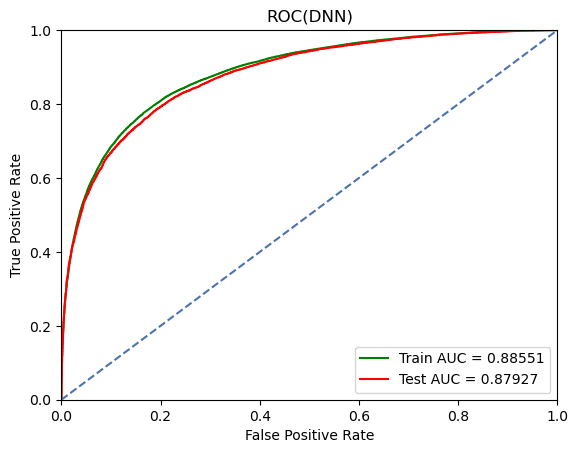

In [102]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(train_label,train_score,sample_weight=train_weight)
roc_auc_train = sklearn.metrics.auc(fpr, tpr)

fprt, tprt, threshold=sklearn.metrics.roc_curve(test_label,test_score,sample_weight=test_weight)
roc_auc_test = sklearn.metrics.auc(fprt, tprt)

plt.style.use('default')
plt.title('ROC(DNN)')
plt.plot(fpr, tpr, 'b',label = 'Train AUC = %0.5f' % roc_auc_train,color='green')
plt.plot(fprt, tprt, 'b',label = 'Test AUC = %0.5f' % roc_auc_test,color='red')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1213/roc-GNN.pdf', format='pdf', dpi=500)
plt.show()